<a href="https://colab.research.google.com/github/cqkh42/boris_vs_keir/blob/main/Boris_vs_Keir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boris vs Keir

Is it a bird, it a plane, is it a blonde baffoon who spends 99% of his life just winging it, or is it a knight of the realm, former Director of Public Prosecutions and real life embodiment of Mark Darcy.

Let's let the model decide.

In [1]:
!pip install -Uqq fastai
!pip install -Uqq jmd_imagescraper

     |████████████████████████████████| 194kB 18.2MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 


In [2]:
import shutil
from pathlib import Path
import tempfile

import fastai.vision.all as vision
import fastai.vision.widgets as vision_widgets
from google.colab import drive
import jmd_imagescraper.core as imagescraper
import requests

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
TARRED_DATA = Path() / 'gdrive' / 'MyDrive' / 'colab' / 'images.tar.gz'

In [5]:
if not TARRED_DATA.exists():
    # let's download some data
    with tempfile.TemporaryDirectory() as tmpdirname:
        p = Path(tmpdirname) / 'images'
        p.mkdir()
        for category in ['boris johnson', 'keir starmer']:
            imagescraper.duckduckgo_search(
                p, category, category, max_results=1000, 
                img_layout=imagescraper.ImgLayout.All
            )
        !tar --directory=$tmpdirname -czf $TARRED_DATA images/

!rm -rf images/
!tar -xzf $TARRED_DATA
IMAGES = Path() / 'images'
len(list(IMAGES.rglob('*')))

1469

In [6]:
data_block = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.CategoryBlock), 
    get_items=vision.get_image_files, 
    splitter=vision.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=vision.parent_label,
    item_tfms=vision.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=vision.aug_transforms()
)

In [7]:
data_loaders = data_block.dataloaders(IMAGES)

In [8]:
learn = vision.cnn_learner(data_loaders, vision.resnet18, metrics=vision.error_rate)
learn.fine_tune(30)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.649869,0.344233,0.129693,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.208837,0.267042,0.133106,00:07
1,0.149938,0.236776,0.116041,00:07
2,0.115787,0.200001,0.095563,00:07
3,0.083156,0.176437,0.081911,00:07
4,0.072584,0.185036,0.075085,00:07
5,0.069779,0.106206,0.044369,00:07
6,0.059965,0.184389,0.075085,00:07
7,0.053928,0.167216,0.061433,00:07
8,0.048989,0.338322,0.081911,00:07
9,0.046331,0.381057,0.109215,00:07


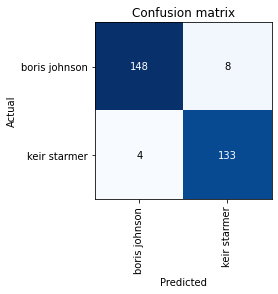

In [9]:
interp = vision.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

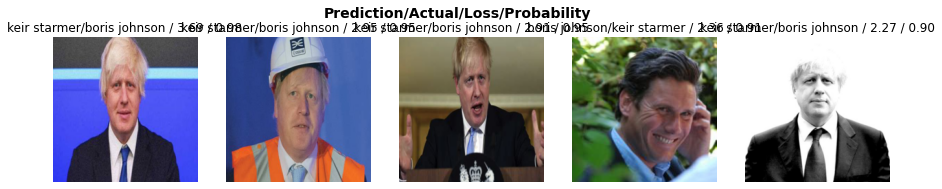

In [10]:
interp.plot_top_losses(5, nrows=1)

In [11]:
cleaner = vision_widgets.ImageClassifierCleaner(learn)
cleaner

In [12]:
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): 
    shutil.move(str(cleaner.fns[idx]), IMAGES/cat)

In [13]:
!tar -czf $TARRED_DATA images/
len(list(IMAGES.rglob('*')))

1469